# Simulation for dynamic BEMB
This notebook simulates dataset to test performances of dynamic embedding models for the student proficiencies.

Author: Tianyu Du

Date: May. 11, 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

plt.style.use(['science', 'no-latex'])

# Configure the Size of the Simulation

**Important Notation**: we use $u$ (stands for user) to denote student and $i$ (stands for item) to denote question.

In [2]:
NUM_STUDENTS = 100
NUM_MATH_QUESTIONS = 500
NUM_ENGLISH_QUESTIONS = 500
NUM_QUESTIONS = NUM_MATH_QUESTIONS + NUM_ENGLISH_QUESTIONS
AVG_QUESTION_PER_DAY = 5
TOTAL_DAYS = 7

# Generate Students' Initial Proficiencies $\theta_u^0$
The student (indexed by $u$) latents $\theta_u$ represents the **student proficiencies** here.

$$
\theta_u^0 \overset{i.i.d.}{\sim} \text{Unif}([0, 1]^2)
$$

For this simulation, we assume student and question latents are living in $\mathbb{R}^2$. Further, we assume the x-axis measures `language skills` and the y-axis measures `math skills` (so the latent is not *really* latent).

Students' initial proficiencies are generated by a uniform distribution.

In [3]:
theta_0 = torch.rand(NUM_STUDENTS, 2)

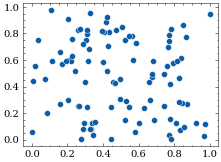

In [4]:
sns.scatterplot(x=theta_0.numpy().T[0], y=theta_0.numpy().T[1])
plt.show()

# Generate Questions' Difficulties $\beta_i$

We assume questions (indexed by $i$) fall into two categories: English and Math. The latent $\beta_i$ represents the **difficulty** of the question.
For example, for a student with high proficiency in English, the inner product of $\theta_u^t$ and $\beta_i$ should be high for English questions.

Difficulties of English questions are generated following 

$$
\beta_i^{English} \overset{i.i.d.}{\sim} \mathcal{N}([0.7, 0.1], 0.1I)
$$

so that they require a high proficiency in English (i.e., the x-axis).

Difficulties of Math questions are generated following

$$
\beta_i^{Math} \overset{i.i.d.}{\sim} \mathcal{N}([0.1, 0.7], 0.1I)
$$

In [5]:
mu_english = torch.Tensor([[0.7, 0.1]])
mu_math = torch.Tensor([[0.1, 0.7]])

In [6]:
beta_english = torch.randn(NUM_ENGLISH_QUESTIONS, 2) * 0.1 + mu_english
beta_math = torch.randn(NUM_MATH_QUESTIONS, 2) * 0.1 + mu_math
beta = torch.cat([beta_english, beta_math], dim=0)

The following figure shows the distribution of difficulties of questions and proficiencies of students.

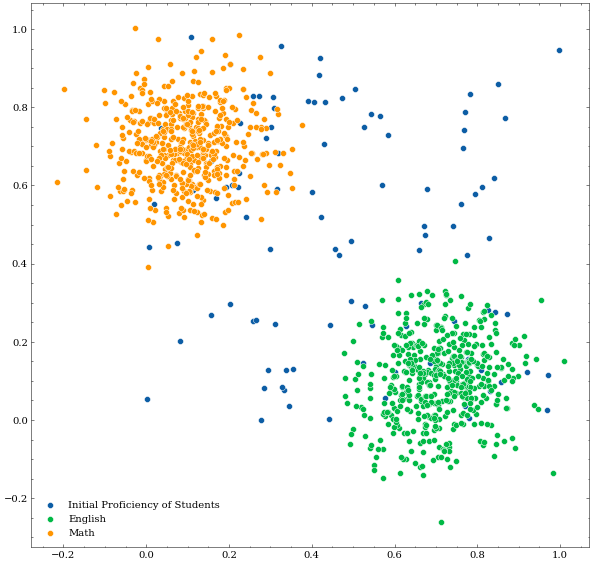

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=theta_0.numpy().T[0], y=theta_0.numpy().T[1], ax=ax, label='Initial Proficiency of Students')
sns.scatterplot(x=beta_english.numpy().T[0], y=beta_english.numpy().T[1], ax=ax, label='English')
sns.scatterplot(x=beta_math.numpy().T[0], y=beta_math.numpy().T[1], ax=ax, label='Math')
ax.legend()
plt.show()

# Generate Student-Question Response
Now we generate the actual dataset of students-questions-responses (i.e., either they answered correctly or incorrectly).

Specifically, for each time $t$ and each student $u$,
* We assume the student $u$ attempts $K \sim Poisson(\lambda)$ questions, where $\lambda$ is controlled by `AVG_QUESTION_PER_DAY`. Let $\mathcal{Q}$ denote the set of questions that the student $u$ attempted, $\mathcal{Q}$ is different for different students.
* We randomly sample $K$ questions from the pool of questions and the student $u$ answers these questions.
* The probability for student $u$ to answer question $i$ correctly is
  
$$
\frac{1}{1 + \exp^{-\theta_u^t \cdot \beta_i}}
$$

* The student's proficiency is updated according to the following rule so that students are learning from attempting these questions:
$$
    \theta_u^{t+1} = \theta_u^t + \alpha \frac{1}{K} \sum_{i \in \mathcal{Q}} \beta_i
$$
where the learning rate $\alpha \sim \text{Unif}([0.01, 0.02])$.

In [8]:
record = list()
true_theta_list = [theta_0]
# ALPHA = 0.01

for t in range(TOTAL_DAYS):
    # Generate # of questions each student tried this day.
    K_list = torch.poisson(torch.Tensor([AVG_QUESTION_PER_DAY] * NUM_STUDENTS))

    new_theta_all_students = list()
    
    for u in range(NUM_STUDENTS):
        K = int(K_list[u])
        if K > 0:
            I_list = torch.randperm(NUM_QUESTIONS)[:K]
            theta_ut = true_theta_list[-1][u].view(2, 1)
            beta_answered = beta[I_list, :]  # (K, 2)
            p = (beta_answered @ theta_ut).squeeze(dim=1)  # (K, )
            response = torch.bernoulli(torch.sigmoid(p))  # (K, )
            
            record_chunk = pd.DataFrame(data={'student_index': u, 'question_index': I_list.numpy(), 'response': response.numpy(), 'time': t})
            record.append(record_chunk)

            ALPHA = np.random.rand() * 0.01 + 0.01
            learned = beta_answered.mean(dim=0) * ALPHA  # (2, )
            new_theta = theta_ut.view(2, ) + learned
            new_theta_all_students.append(new_theta)
        else:
            new_theta_all_students.append(true_theta_list[-1][u])
    
    new_theta = torch.stack(new_theta_all_students, dim=0)
    true_theta_list.append(new_theta)

df_resp = pd.concat(record, ignore_index=True)

In [9]:
df_resp

,student_index,question_index,response,time
0,0,685,1.0,0
1,0,665,0.0,0
2,0,469,1.0,0
3,0,583,0.0,0
4,0,841,1.0,0
...,...,...,...,...
3464,98,301,0.0,6
3465,98,562,1.0,6
3466,99,723,1.0,6
3467,99,787,0.0,6


The figure below demonstrates the behavior of dynamic proficiencies of students in 10 time periods, we can see that $\theta$'s are drifting to the top-right corner.

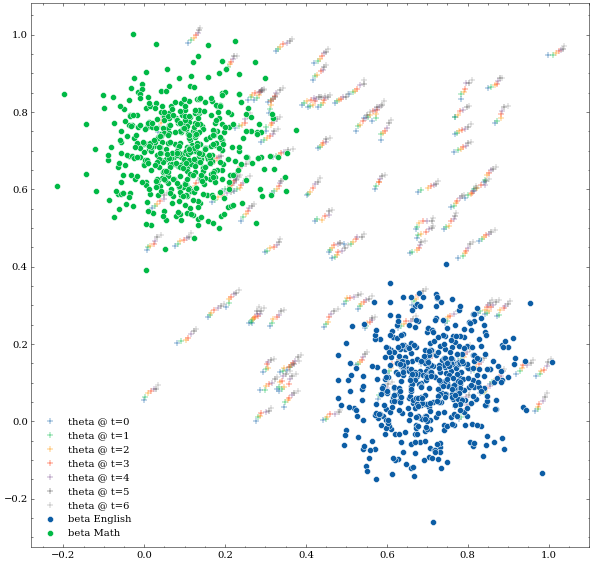

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
for t in range(TOTAL_DAYS):
    sns.scatterplot(x=true_theta_list[t].numpy().T[0], y=true_theta_list[t].numpy().T[1], ax=ax, label=f'theta @ t={t}', marker='+')
sns.scatterplot(x=beta_english.numpy().T[0], y=beta_english.numpy().T[1], ax=ax, label='beta English')
sns.scatterplot(x=beta_math.numpy().T[0], y=beta_math.numpy().T[1], ax=ax, label='beta Math')
ax.legend()
plt.show()

# We Encompass Everything Simulated in a `ChoiceDataset` Structure

In [78]:
from torch_choice.data import ChoiceDataset
dataset = ChoiceDataset(user_index=torch.LongTensor(df_resp['student_index'].values),
                        item_index=torch.LongTensor(df_resp['question_index'].values),
                        label=torch.LongTensor(df_resp['response'].values),
                        time=torch.LongTensor(df_resp['time'].values))
print(dataset)

No `session_index` is provided, assume each choice instance is in its own session.


# Build the `Pyro` Model

In [82]:
import pyro
import torch

import pyro.distributions as dist
import pyro.optim as optim
from torch.distributions import constraints


# this is important.
pyro.clear_param_store()


def pred_fn_factorization(theta, alpha, beta, stu_id, ques_id):
    theta_i = theta[stu_id, :]
    alpha_j = alpha[ques_id, :]
    beta_j = beta[ques_id]
    u = torch.sum(alpha_j * theta_i, dim = 1) - beta_j
    prob = torch.sigmoid(u)
    return prob

def model_factorization(ques_id, stu_id, correct, n_latent, n_ques = None, n_stu = None):
    if not n_ques: n_ques = torch.unique(ques_id).size()[0]
    if not n_stu: n_stu = torch.unique(stu_id).size()[0]

    # link params to models defined in model function
    theta = pyro.sample("theta", dist.Normal(torch.zeros(n_stu, n_latent), torch.ones(n_stu, n_latent)).independent(2))
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(n_ques, n_latent), torch.ones(n_ques, n_latent)).independent(2))
    beta = pyro.sample("beta", dist.Normal(torch.zeros(n_ques), torch.ones(n_ques)).independent(1))

    # actual parameters corresponding to data
    prob = pred_fn_factorization(theta, alpha, beta, stu_id, ques_id)

    with pyro.plate("data", len(correct)):
        pyro.sample("obs", dist.Bernoulli(prob), obs=correct)

def guide_factorization(ques_id, stu_id, correct, n_latent, n_ques = None, n_stu = None):
    if not n_ques: n_ques = torch.unique(ques_id).size()[0]
    if not n_stu: n_stu = torch.unique(stu_id).size()[0]

    theta_loc = pyro.param('theta_loc', torch.randn(n_stu, n_latent, dtype = torch.float64) / 100.)
    theta_scale = pyro.param('theta_scale', torch.ones(n_stu, n_latent, dtype = torch.float64),
                               constraint=constraints.positive)

    alpha_loc = pyro.param('alpha_loc', torch.ones(n_ques, n_latent, dtype = torch.float64),
                               constraint=constraints.positive)

    alpha_scale = pyro.param('alpha_scale', torch.ones(n_ques, n_latent, dtype = torch.float64),
                               constraint=constraints.positive)

    beta_loc = pyro.param('beta_loc', torch.randn(n_ques, dtype = torch.float64) / 100.)
    beta_scale = pyro.param('beta_scale', torch.ones(n_ques, dtype = torch.float64),
                               constraint=constraints.positive)

    # link params to models defined in model function
    pyro.sample("theta", dist.Normal(theta_loc, theta_scale).independent(2))
    pyro.sample("alpha", dist.Normal(alpha_loc, alpha_scale).independent(2))
    pyro.sample("beta", dist.Normal(beta_loc, beta_scale).independent(1))

In [80]:
from pyro.infer import SVI, Trace_ELBO
lr = 0.01
svi = SVI(model_factorization, guide_factorization, optim.Adam({"lr": lr}), loss=Trace_ELBO())

In [83]:
losses = []
for step in range(1000):
    # loss = svi.step(data_dict['ques_id'], data_dict['stu_id'], data_dict['correct'], n_ques = data_dict['n_ques'], n_stu = data_dict['n_stu'])
    loss = svi.step(dataset.item_index, dataset.user_index, dataset.label.float(), 50, n_ques = NUM_QUESTIONS, n_stu = NUM_STUDENTS)
    losses.append(loss)
    if step % 100 == 0:
        prob = pred_fn_factorization(pyro.get_param_store()['theta_loc'], pyro.get_param_store()['alpha_loc'],
                                     pyro.get_param_store()['beta_loc'],
                                     dataset.user_index,
                                     dataset.item_index)
        pred = (prob >= 0.5).float()
        print('Acc:', (pred == dataset.label).float().mean())
        print("Elbo loss: {}".format(loss))

Acc: tensor(0.4762)
Elbo loss: 39151.363713926985
Acc: tensor(0.3788)
Elbo loss: 19865.586429710664
Acc: tensor(0.3448)
Elbo loss: 13974.857332004078
Acc: tensor(0.3237)
Elbo loss: 11293.858382418272
Acc: tensor(0.3122)
Elbo loss: 9923.184736890062
Acc: tensor(0.3056)
Elbo loss: 9062.3162500197
Acc: tensor(0.2963)
Elbo loss: 8882.164839182344
Acc: tensor(0.2926)
Elbo loss: 8353.339788302093
Acc: tensor(0.2903)
Elbo loss: 8278.813353693444
Acc: tensor(0.2854)
Elbo loss: 7739.380236808134
